In [1]:
import numpy as np
import pandas as pd

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

In [66]:
df_train = pd.read_csv('./train.csv', 
                       dtype={
                           'question1': np.str,
                           'question2': np.str
                       })
df_train['test_id'] = -1
df_test = pd.read_csv('./test.csv', 
                      dtype={
                          'question1': np.str,
                          'question2': np.str
                      })
df_test['id'] = -1
df_test['qid1'] = -1
df_test['qid2'] = -1
df_test['is_duplicate'] = -1

df = pd.concat([df_train, df_test])
df['question1'] = df['question1'].fillna('')
df['question2'] = df['question2'].fillna('')
df['uid'] = np.arange(df.shape[0])
df = df.set_index(['uid'])
print (df.dtypes)
del(df_train, df_test)

id               int64
is_duplicate     int64
qid1             int64
qid2             int64
question1       object
question2       object
test_id          int64
dtype: object


In [67]:
df['len1'] = df['question1'].str.len()
df['len2'] = df['question2'].str.len()

In [68]:
%%time
df['is_first_word_equal'] = df.apply(
    lambda r: int(r['question1'].split(' ')[0] == r['question2'].split(' ')[0]), axis=1)

CPU times: user 2min 9s, sys: 280 ms, total: 2min 9s
Wall time: 2min 9s


In [69]:
df['abs_diff_len1_len2'] = np.abs(df['len1'] - df['len2'])

In [70]:
ix_train = df['is_duplicate'] != -1
ix_test = df['is_duplicate'] == -1

In [3]:
from textblob import TextBlob
from textblob import Word

In [4]:
from nltk.corpus import stopwords

In [73]:
def remove_stopwodrs(text):
    stopwords = nltk.corpus.stopwords.words('english')
    content = [w for w in TextBlob(text).words if w.lower() not in stopwords]
    return content

In [74]:
%%time
q1 = []
for x in df.question1:
    q1.append(' '.join(set(remove_stopwodrs(x))))
df['q1_without_stopwords'] = q1

CPU times: user 23min 38s, sys: 30.6 s, total: 24min 9s
Wall time: 24min 10s


In [75]:
%%time
q2 = []
for x in df.question2:
    q2.append(' '.join(set(remove_stopwodrs(x))))
df['q2_without_stopwords'] = q2

CPU times: user 24min 39s, sys: 31.6 s, total: 25min 11s
Wall time: 46min 54s


In [76]:
### посмотреть отдельно общие глаголы и существительные, относительно кол-ва слов, глянуть на значимость
### check similarity

In [77]:
# df['unique_words_density'] = df.apply(
#    lambda r: r['unique_words_number'] / (r['len1'] + r['len2']), axis = 1)

In [78]:
def syn_words(text):
    syns = []
    for x in TextBlob(text).words:
        for synset in Word(x).synsets:
            syns.append(synset.name().split('.')[0])
    return syns

In [79]:
%%time
df['unique_syn'] = df.apply(
    lambda r: set(syn_words(r['q1_without_stopwords'])).intersection(set(syn_words(r['q2_without_stopwords']))), axis = 1)

CPU times: user 53min 42s, sys: 13.1 s, total: 53min 55s
Wall time: 1h 3min 38s


In [80]:
df.to_csv('new_train.csv', index = False)

In [82]:
df.shape

(2750086, 14)

In [83]:
len(df['unique_syn'])

2750086

In [3]:
df1 = pd.read_csv('new_train.csv')

In [6]:
df1.shape

(2750086, 14)

In [5]:
data = df1.dropna()

In [8]:
data.shape

(2727367, 14)

In [9]:
eq_num = []
for x in data.unique_syn:
    eq_num.append(len(x))

In [10]:
data['equal_syn_number'] = eq_num

/home/aragret/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


In [13]:
data.head()

,id,is_duplicate,qid1,qid2,question1,question2,test_id,len1,len2,is_first_word_equal,abs_diff_len1_len2,q1_without_stopwords,q2_without_stopwords,unique_syn,equal_syn_number,eq_syn_number
0,0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,-1,66,57,1,9,share invest step india market guide,share invest step market guide,"{'footprint', 'invest', 'tone', 'pace', 'comme...",327,2.658537
1,1,0,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,-1,51,88,1,37,story Diamond Kohinoor Koh-i-Noor,back happen Indian diamond stole would governm...,"{'baseball_diamond', 'rhombus', 'diamond', 'ba...",56,0.402878
2,2,0,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,-1,73,59,1,14,internet using speed connection VPN increase,speed hacking increased DNS Internet,"{'internet', 'speed', 'focal_ratio', 'travel_r...",103,0.780303
3,3,0,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,-1,50,65,0,15,lonely mentally solve,"remainder math divided 24 23 24,23 Find",set(),5,0.043478
4,4,0,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,-1,76,39,1,37,sugar water salt one di methane oxide dissolve...,water salt fish would survive,"{'urine', 'body_of_water', 'salt', 'water', 's...",94,0.817391


In [11]:
def plot_real_feature(fname):
    fig = plt.figure()
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=2)
    ax2 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    ax3 = plt.subplot2grid((3, 2), (2, 0))
    ax4 = plt.subplot2grid((3, 2), (2, 1))
    ax1.set_title('Distribution of %s' % fname, fontsize=20)
    sns.distplot(data.loc[ix_train][fname], 
                 bins=50, 
                 ax=ax1)    
    sns.distplot(data.loc[ix_is_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='is dup')    
    sns.distplot(data.loc[ix_not_dup][fname], 
                 bins=50, 
                 ax=ax2,
                 label='not dup')
    ax2.legend(loc='upper right', prop={'size': 18})
    sns.boxplot(y=fname, 
                x='is_duplicate', 
                data=data.loc[ix_train], 
                ax=ax3)
    sns.violinplot(y=fname, 
                   x='is_duplicate', 
                   data=data.loc[ix_train], 
                   ax=ax4)
    plt.show()

In [15]:
ix_train = data['is_duplicate'] != -1
ix_test = data['is_duplicate'] == -1

In [12]:
data['eq_syn_number'] = data.apply(lambda r: r['equal_syn_number'] / (r['len1'] + r['len2']), axis = 1)

/home/aragret/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


Populating the interactive namespace from numpy and matplotlib


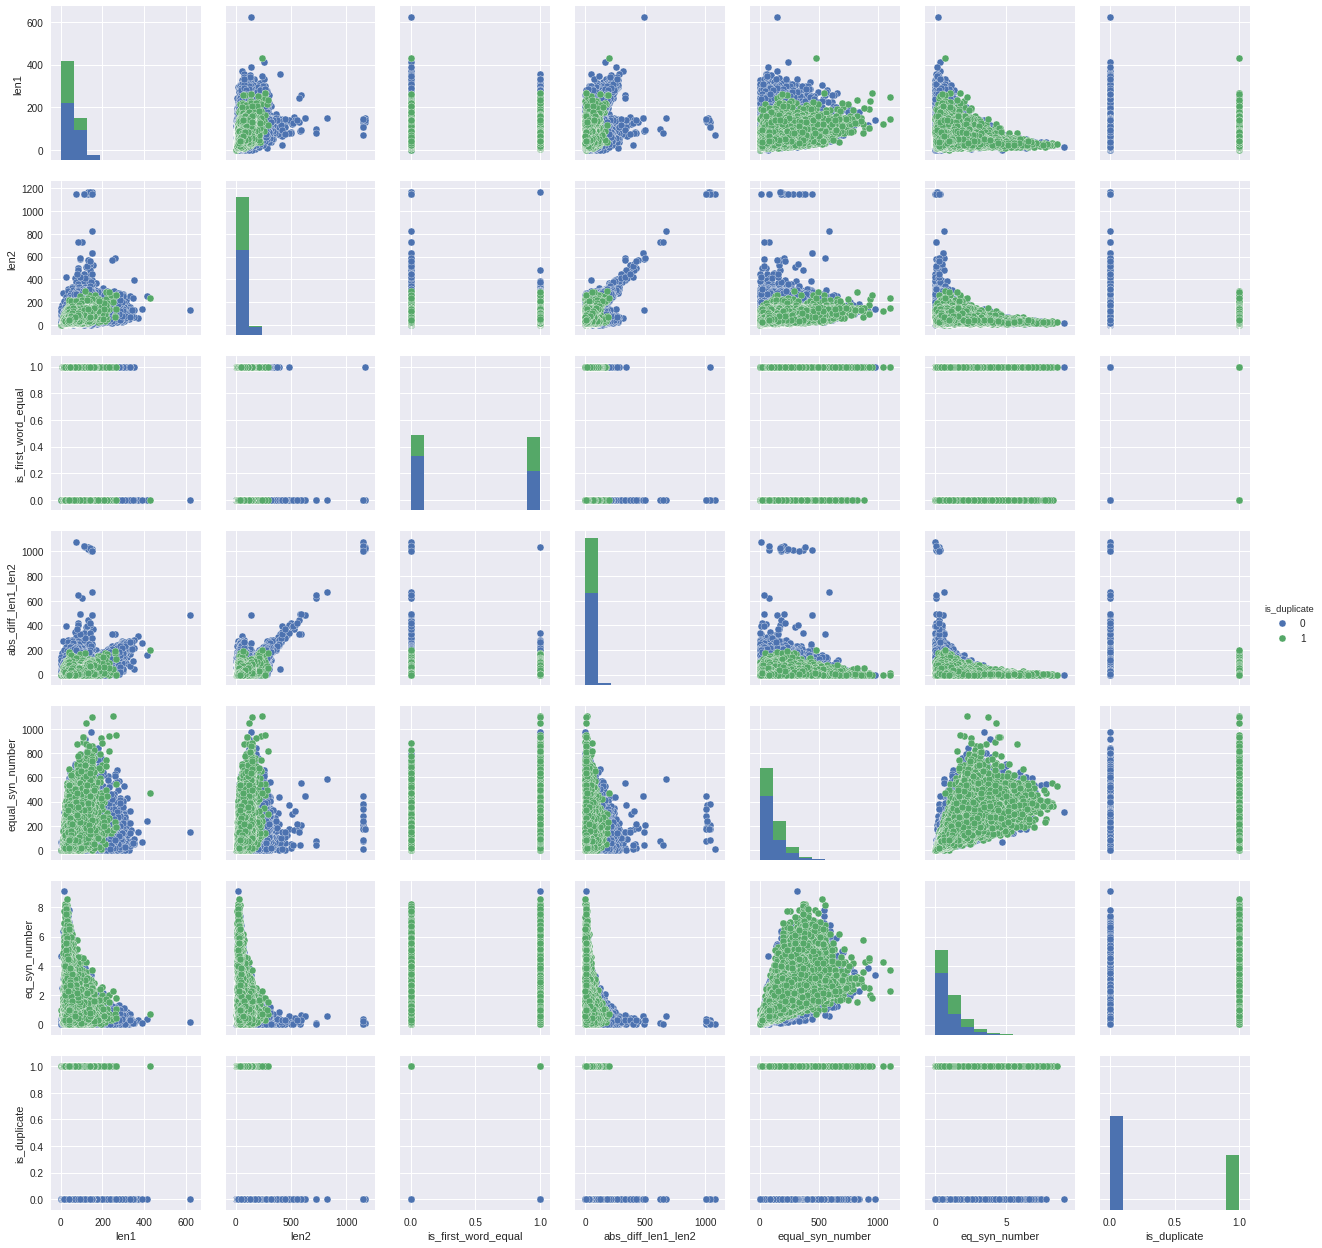

In [16]:
%pylab inline
sns.pairplot(data.loc[ix_train][data.columns[7:].tolist() + ['is_duplicate']], hue="is_duplicate")

In [ ]:
### bigrams ###

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

cv_char = CountVectorizer(ngram_range=(2, 2), analyzer='char')
ch_freq = np.array(cv_char.fit_transform(data['q1_without_stopwords'].tolist() + data['q2_without_stopwords'].tolist()).sum(axis=0))[0, :]

In [ ]:
bigrams = dict([(k, v) for (k, v) in cv_char.vocabulary_.items()])
ix_bigrams = np.sort(bigrams.values())
print ('Bigrams: ', len(bigrams))